In [10]:
import numpy as np
import pandas as pd
import random
import shap
from math import sqrt
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.linear_model import LinearRegression

In [11]:
#individuals
n = 2000
#loci
m = 100


#here every matrix entree has to be zero or one, with having a f_i probability to get selected
#frequency of alleles, random uniform distribution between 0 and 1, with m samples
f_M = np.random.uniform(0,1,m)

#initialize G matrix
# G = np.zeros((n, m));

# #will be used to flip a coin based on f_i
# #higher f_i frequency = higher chance of returning true
# def loci_frequency_flip(f_i):
#     return random.random() < f_i

# #use this if I wanted to populate entire G matrix
# #k are the colums(loci)
# for k in range (0, len(G[0])):
#     # j are the rows(individuals)
#     for j in range (0, len(G)):
#         #frequency of loci k we are currently on
#         if(loci_frequency_flip(f_M[k])):
#             G[j,k] = 1

G = np.random.binomial(n=2,p = f_M, size =  (n,m))

# If 0, independently standardize each feature, otherwise (if 1) standardize each sample, so choosing 0 
# to do column wise scaling
G = preprocessing.scale(G, axis=0)
# choose random SNP
loci =random.randint(0,m-1)

#select SNP
SNP = G[:,loci]

#preview of the data
print(SNP[0:30])

Data with input dtype int32 was converted to float64 by the scale function.


[ 1.53176192 -1.32467056  0.10354568 -1.32467056  1.53176192  0.10354568
  1.53176192  1.53176192  0.10354568  0.10354568  1.53176192 -1.32467056
  0.10354568 -1.32467056  1.53176192  0.10354568  1.53176192 -1.32467056
  0.10354568  0.10354568 -1.32467056 -1.32467056 -1.32467056  0.10354568
  0.10354568 -1.32467056  0.10354568  1.53176192  1.53176192  1.53176192]


In [12]:

# mean and standard deviation
H=0
#assumes that we are making a Y_j for every individual in the SNP and 
#in each loop we choose a e_j for that person
def Simulate_Phenotype_PerPerson(SNP,var_e,var_g):
    #rows are the loci so each person has a row of different loci
    individuals = len(SNP)
    
    #where columns are the individuals
    mean = 0 
    
    #because we are given variance and python random.normal only accepts std, we need to convert variance to std
    sigma_e = sqrt(var_e)
    sigma_b = sqrt(var_g)
    
    #b_i = loci effect on phenotype
    b_i = np.random.normal(0, sigma_b)
    Y_n = np.zeros((individuals, 1));
    
    for k in range(0, individuals):
        #each individual will have a random e_j(noise) value
        e_j = np.random.normal(0, sigma_e)
        #G_ij will be the jth individual from our SNP for the loci of choce
        G_ij  = SNP[k]
        Y_j = b_i*G_ij + e_j
        Y_n[k] = Y_j 
    H= var_g/(var_g+var_e)
    return Y_n,H


In [36]:
#Generate Genotype
def generate_genotype(n, m):
    f_M = np.random.uniform(0,1,m)
    G = np.random.binomial(n=2,p = f_M, size =  (n,m))
    G = preprocessing.scale(G, axis=0)
    return G
    
#Generate Phenotype, 2 SNP no interaction
def generate_phenotype_no_interaction(G, var_g, var_e):
    individuals = len(G) 
    #Convert variance to sigma for python
    sigma_e = sqrt(var_e)
    sigma_b = sqrt(var_g/2)
    
    #b_i = loci effect on phenotype
    b_1 = np.random.normal(0, sigma_b)
    b_2 = np.random.normal(0, sigma_b)

    Y_n = np.zeros((individuals, 1));
    
    #Select loci
    loci =random.sample(range(0, individuals), 2)
    SNP1 = G[:,loci[0]]
    SNP2 = G[:,loci[1]]
    
    #Create Phenotype
    for k in range(0, individuals):
        #each individual will have a random e_j(noise) value
        e_j = np.random.normal(0, sigma_e)
        #G_ij will be the jth individual from our SNP for the loci of choice
        G_ij1  = SNP1[k]
        G_ij2  = SNP2[k]
        Y_j = (b_1*G_ij1) + (b_2*G_ij2) + e_j
        Y_n[k] = Y_j 
    return Y_n

#Generate base phenotype values
def generate_base_pheno_values(G, var_g, var_e):
    #rows are the loci so each person has a row of different loci
    individuals = len(G)    
    sigma_e = sqrt(var_e)
    sigma_b = sqrt(var_g/2)
    #b_i = loci effect on phenotype
    b_1 = np.random.normal(0, sigma_b)
    b_2 = np.random.normal(0, sigma_b)
    
    loci =random.sample(range(0, individuals), 2)
    SNP1 = G[:,loci[0]]
    SNP2 = G[:,loci[1]]
    return b_1, b_2, SNP1, SNP2, sigma_e, sigma_b
'''
#Generate Phenotype, 2 SNP additive interaction
def generate_phenotype_no_interaction(b_1, b_2, SNP1, SNP2, sigma_e, sigma_b):
    individuals = len(SNP1)    
    #rows are the loci so each person has a row of different loci
    Y_n = np.zeros((individuals, 1));

    for k in range(0, individuals):
        #each individual will have a random e_j(noise) value
        e_j = np.random.normal(0, sigma_e)
        #G_ij will be the jth individual from our SNP for the loci of choice
        G_ij1  = SNP1[k]
        G_ij2  = SNP2[k]
        Y_j = (b_1*G_ij1) + (b_2*G_ij2) + e_j
        Y_n[k] = Y_j 
        b_12 = 0
    return Y_n, b_12
'''
#Generate Phenotype, 2 SNP combined interaction
def generate_phenotype_combined_effect(b_1, b_2, SNP1, SNP2, sigma_e, sigma_b):
    individuals = len(SNP1)    
    #rows are the loci so each person has a row of different loci
    Y_n = np.zeros((individuals, 1));
    b_12 = np.random.normal(0, sigma_b)
    for k in range(0, individuals):
        #each individual will have a random e_j(noise) value
        e_j = np.random.normal(0, sigma_e)
        #G_ij will be the jth individual from our SNP for the loci of choice
        G_ij1  = SNP1[k]
        G_ij2  = SNP2[k]
        Y_j = (b_1*G_ij1) + (b_2*G_ij2) + (b_12 * G_ij1 * G_ij2)+ e_j 
        Y_n[k] = Y_j 
    return Y_n, b_12

#Generate Phenotype, 2 SNP positive interaction
def generate_phenotype_combined_positive_effect(b_1, b_2, SNP1, SNP2, sigma_e, sigma_b):
    individuals = len(SNP1)    
    #rows are the loci so each person has a row of different loci
    Y_n = np.zeros((individuals, 1));
    b_12 = np.random.normal(0, sigma_b)
    for k in range(0, individuals):
        #each individual will have a random e_j(noise) value
        e_j = np.random.normal(0, sigma_e)
        #G_ij will be the jth individual from our SNP for the loci of choice
        G_ij1  = SNP1[k]
        G_ij2  = SNP2[k]
        Y_j = (b_1*G_ij1) + (b_2*G_ij2) + (b_12 * G_ij1 * G_ij2)+ e_j 
        Y_n[k] = Y_j 
    return Y_n, b_12
#Generate Phenotype, 2 SNP detrimental interaction
def generate_phenotype_combined_negative_effect(b_1, b_2, SNP1, SNP2, sigma_e, sigma_b):
    individuals = len(SNP1)    
    #rows are the loci so each person has a row of different loci
    Y_n = np.zeros((individuals, 1));
    b_12 = np.random.normal(0, sigma_b)
    for k in range(0, individuals):
        #each individual will have a random e_j(noise) value
        e_j = np.random.normal(0, sigma_e)
        #G_ij will be the jth individual from our SNP for the loci of choice
        G_ij1  = SNP1[k]
        G_ij2  = SNP2[k]
        Y_j = (b_1*G_ij1) + (b_2*G_ij2) + (b_12 * G_ij1 * G_ij2)+ e_j 
        Y_n[k] = Y_j 
    return Y_n, b_12
#b_1, b_2, SNP1, SNP2, sigma_e, sigma_b = generate_base_pheno_values(G, 0.7, 0.3)
#print(generate_phenotype_no_interaction(b_1, b_2, SNP1, SNP2, sigma_e, sigma_b))
#print(generate_phenotype_combined_effect(b_1, b_2, SNP1, SNP2, sigma_e, sigma_b))

G = generate_genotype(5, 10)
#print(G[0:10])
#print(generate_phenotype_no_interaction(G, 0.7, 0.3))
b_1, b_2, SNP1, SNP2, sigma_e, sigma_b = 
print(generate_phenotype_combined_effect(generate_base_pheno_values(G, 0.7, 0.3)))

TypeError: generate_phenotype_combined_effect() missing 5 required positional arguments: 'b_2', 'SNP1', 'SNP2', 'sigma_e', and 'sigma_b'

In [6]:
#Plot Interaction to Bi
#x = bi
#y = phenotype effect
def phenotype_plotting(phenotypes):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-6-5b7832c94655>, line 5)

In [14]:
Simulate_Phenotype_PerPerson(SNP, .3, .7)

(array([[-3.5202367 ],
        [ 3.63668976],
        [-0.25185634],
        ...,
        [ 0.78573735],
        [-0.68258088],
        [ 3.4694166 ]]), 0.7)

In [15]:
Y,H = Simulate_Phenotype_PerPerson(SNP,.3,.7)

In [16]:
# function assumes that for each person j in M we make a phenotype Y_j
print('Phenotypes for loci '+str(loci)+' are '+str(Y[0:30]))

Phenotypes for loci 4 are [[-0.81042649]
 [ 3.26132211]
 [-0.21412352]
 [ 1.80196666]
 [-1.19573896]
 [ 0.37132478]
 [-2.29632598]
 [-1.70030384]
 [ 0.44957674]
 [-0.71858628]
 [-1.59291868]
 [ 1.65104935]
 [-0.76357433]
 [ 1.42310673]
 [-1.72462703]
 [-0.20532795]
 [-1.8611489 ]
 [ 1.23502354]
 [-0.95846395]
 [ 0.18752882]
 [ 1.31256505]
 [ 1.91339849]
 [ 1.71302852]
 [ 0.58293801]
 [-0.77536867]
 [ 2.03204838]
 [-0.1605981 ]
 [-1.54008765]
 [-2.38287792]
 [-2.7796511 ]]


In [17]:
G = np.append(G, Y, axis=1)

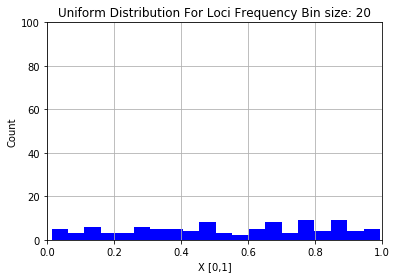

In [18]:
#use this to see distribution of f_i frequency
bin_size = 20
count, bins, ignored = plt.hist(f_M, 20, facecolor='blue') 

plt.xlabel('X [0,1]')
plt.ylabel('Count')
plt.title("Uniform Distribution For Loci Frequency Bin size: "+str(bin_size))
plt.axis([0, 1, 0, 100]) # x_start, x_end, y_start, y_end
plt.grid(True)

plt.show(block = False)

In [19]:
#starting machine learning classification
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.linear_model import LinearRegression

In [20]:
#split data into test and train
X = G[:,0:len(G[0])-2]

#last column is the appended Y vector we predicted
y = G[:,len(G[0])-1]

#split the data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

In [21]:
linReg = LinearRegression()  

In [22]:
#training the algorithm
linReg.fit(x_train, y_train) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [47]:
#regression model of SVM with RBF kernal
#svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)

In [23]:
# train the model
#svr_rbf.fit(x_train, y_train)

#test the model on test data
y_predict = linReg.predict(x_test)

In [24]:
#Evaluate the regression model
import sklearn.metrics as sm
print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_predict), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y_test, y_predict), 2)) 
print("Root Mean squared error =", sqrt(round(sm.mean_squared_error(y_test, y_predict), 2)))
print("Median absolute error =", round(sm.median_absolute_error(y_test, y_predict), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y_test, y_predict), 2)) 
print("R2 score =", round(sm.r2_score(y_test, y_predict), 2))

Mean absolute error = 0.45
Mean squared error = 0.32
Root Mean squared error = 0.565685424949238
Median absolute error = 0.37
Explain variance score = 0.82
R2 score = 0.82


In [25]:
from sklearn.ensemble import RandomForestRegressor
#initialize tree with a node depth of 10 and 50 decision trees
forReg = RandomForestRegressor(max_depth=10, random_state=0, n_estimators=50)
forReg.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


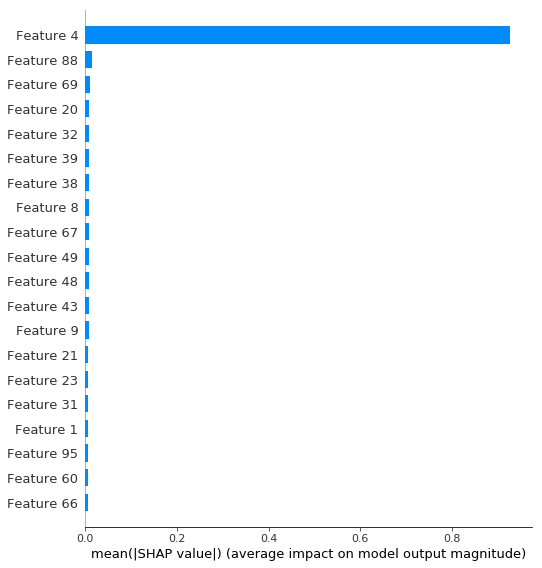

In [26]:
shap_values = shap.TreeExplainer(forReg).shap_values(x_train)
shap.summary_plot(shap_values, x_train, plot_type="bar")

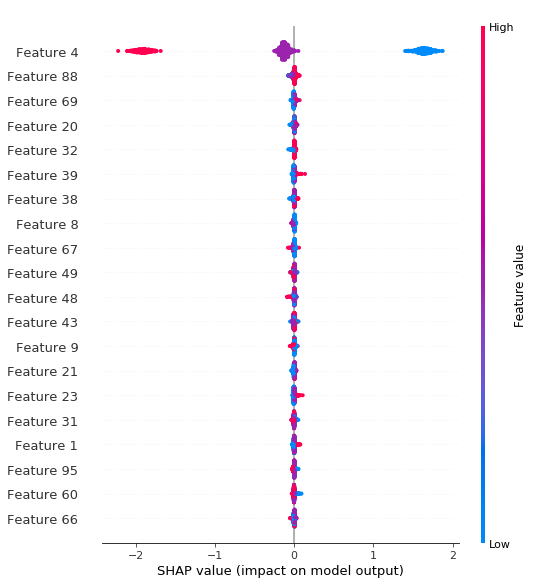

In [27]:
shap.summary_plot(shap_values,x_train)

In [28]:
def trait_simulation(samples_n, loci_m,var_g,var_e):
    f_M = np.random.uniform(0,1,loci_m)
    G = np.random.binomial(n=2,p = f_M, size = (samples_n,loci_m))
    G = preprocessing.scale(G, axis=0)
    loci =random.randint(0,loci_m-1)
    SNP = G[:,loci]
    individuals = len(SNP)
    mean = 0 
    sigma_b = sqrt(var_g)
    sigma_e = sqrt(var_e)
    b_i = np.random.normal(0, sigma_b)
    Y_n = np.zeros((individuals, 1))
    for k in range(0, individuals):
        #each individual will have a random e_j(noise) value
        e_j = np.random.normal(0, sigma_e)
        #G_ij will be the jth individual from our SNP for the loci of choce
        G_ij  = SNP[k]
        Y_j = b_i*G_ij + e_j
        Y_n[k] = Y_j 
    H= var_g/(var_g+var_e)
    G = np.append(G, Y_n, axis=1)
    X = G[:,0:len(G[0])-2]
    y = G[:,len(G[0])-1]
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    linReg = LinearRegression()  
    linReg.fit(x_train, y_train) 
    explainer = shap.KernelExplainer(linReg.predict, x_train)
    shap_values = explainer.shap_values(x_train)
    #print(x_train.shape)
    shap_values = shap_linear_regression(G)
    #print(shap_feature_plot(shap_values))
    return shap_values,loci

In [29]:
#Breaking into smaller functions
def simulate_genotype(samples_n, loci_m):
    f_M = np.random.uniform(0,1,loci_m)
    G = np.random.binomial(n=2,p = f_M, size = (samples_n,loci_m))
    G = preprocessing.scale(G, axis=0)
    return G

def simulate_genotype_and_phenotype(samples_n, loci_m,var_g,var_e):
    G = simulate_genotype(samples_n, loci_m)
    loci =random.randint(0,loci_m-1)
    SNP = G[:,loci]
    individuals = len(SNP)
    mean = 0 
    sigma_b = sqrt(var_g)
    sigma_e = sqrt(var_e)
    b_i = np.random.normal(0, sigma_b)
    Y_n = np.zeros((individuals, 1))
    for k in range(0, individuals):
        #each individual will have a random e_j(noise) value
        e_j = np.random.normal(0, sigma_e)
        #G_ij will be the jth individual from our SNP for the loci of choce
        G_ij  = SNP[k]
        Y_j = b_i*G_ij + e_j
        Y_n[k] = Y_j 
    H= var_g/(var_g+var_e)
    G = np.append(G, Y_n, axis=1)
    return G, loci

In [30]:
#Linear ML functions & SHAP
def shap_linear_regression(G):
    #H= var_g/(var_g+var_e)
    X = G[:,0:len(G[0])-2]
    y = G[:,len(G[0])-1]
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    linReg = LinearRegression()  
    linReg.fit(x_train, y_train) 
    y_predict = linReg.predict(x_test)
    '''
    print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_predict), 2)) 
    print("Mean squared error =", round(sm.mean_squared_error(y_test, y_predict), 2)) 
    print("Root Mean squared error =", sqrt(round(sm.mean_squared_error(y_test, y_predict), 2)))
    print("Median absolute error =", round(sm.median_absolute_error(y_test, y_predict), 2)) 
    print("Explain variance score =", round(sm.explained_variance_score(y_test, y_predict), 2)) 
    print("R2 score =", round(sm.r2_score(y_test, y_predict), 2))
    '''
    root_mean_sqr = sqrt(round(sm.mean_squared_error(y_test, y_predict), 2))
    explainer = shap.KernelExplainer(linReg.predict, x_train)
    shap_values = explainer.shap_values(x_train)
    return shap_values, root_mean_sqr

def shap_feature_plot(shap_values):
    shap_values = shap.TreeExplainer(forReg).shap_values(x_train)
    shap.summary_plot(shap_values, x_train, plot_type="bar")
    
    
    
    

Data with input dtype int32 was converted to float64 by the scale function.


3


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_


0.6244997998398398


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


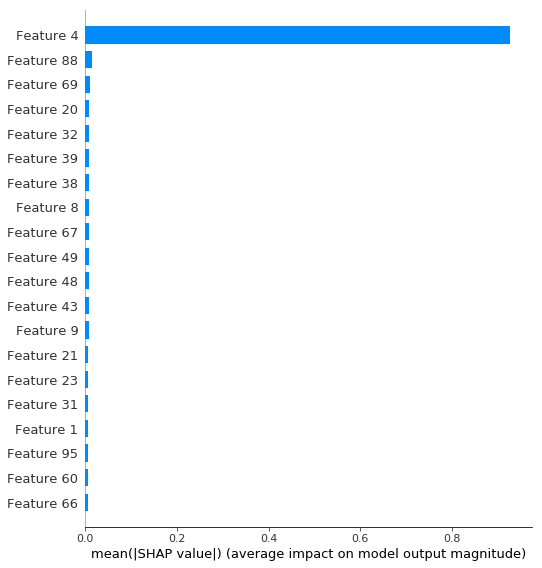

In [31]:
G, loci = simulate_genotype_and_phenotype(30,5, .4, .5)
print(loci)
shap_values, root_mean_sqr = shap_linear_regression(G)
print(root_mean_sqr)
shap_feature_plot(shap_values)

In [32]:
import warnings
warnings.filterwarnings('ignore')
shap_values, SNP = trait_simulation(30,100,.4,.5)

In [33]:
#SHAP vs noise
#def linear_regression_vs_noise(samples_n, loci_m,var_g,var_e, number_of_trials):
def mean_shap_values(shap_values):
    if len(shap_values) == 2:
        mean_shap = [0] * len(shap_values[0][0])
        for shap_value in shap_values[0]:
            #print(shap_value)
            for x in range(0, len(shap_value)):
                mean_shap[x] = mean_shap[x] + shap_value[x]
        for x in range(0, len(shap_values[0])):
            mean_shap[x] = abs(mean_shap[x] / len(shap_values[0]))
    else:    
        mean_shap = [0] * len(shap_values[0])
        for shap_value in shap_values:
            for x in range(0, len(shap_value)):
                mean_shap[x] = mean_shap[x] + shap_value[x]
        for x in range(0, len(shap_values[0])):
            mean_shap[x] = abs(mean_shap[x] / len(shap_values[0]))
    return mean_shap                   

def max_mean_feature(shap_values):
    mean_shap = mean_shap_values(shap_values)
    return mean_shap.index(max(mean_shap)), mean_shap[mean_shap.index(max(mean_shap))]

def avg_shap_values(samples_n, loci_m,var_g,var_e, number_of_trials):
    trail_shap_values = []
    for trail in range(0, number_of_trials):
        shap_values,SNP = trait_simulation(samples_n, loci_m,var_g,var_e)
        max_mean_shap = max_mean_feature(shap_values)
        trail_shap_values.append(max_mean_shap[1])
    return sum(trail_shap_values)/len(trail_shap_values)

def plot_shap_values(samples_n, loci_m, trails):
    
    increment = 1/trails
    holderg = 0
    holdere = 1
    var_g = [0]
    var_e = [1]
    for x in range(1, trails):
        var_g.append(holderg + increment)
        var_e.append(holdere - increment)
        holderg = holderg + increment
        holdere = holdere - increment
    shap_values_SNP = []
    for x in range(0,trails):
        shap_value_holder, SNP = trait_simulation(samples_n, loci_m, var_g[x], var_e[x])
        max_holder = max_mean_feature(shap_value_holder)
        if max_holder[0] == SNP:
            shap_values_SNP.append(max_holder[1])
            print(max_holder[1])
        else:
            shap_values_SNP.append(0)
        
    plt.plot(var_g, shap_values_SNP) 
    plt.xlabel('Variance of Genetic Effect')
    plt.ylabel('SHAP value of causal SNP')
    plt.title('Effective of noise on SHAP values')  
    plt.show()

        
        

In [34]:
#shap_values[0]
#mean = mean_shap_values(shap_values)
#print(mean)
#print(avg_shap_values(20, 100, .3, .7, 5))
#plot_shap_values(20, 30, 10)
SHAP_array, loci = trait_simulation(20,100, 1, 0)
mean = max_mean_feature(shap_values)
print(mean)
print(loci)
if loci == mean[0]:
    print("working")


(55, 0.057158678006314106)
88
